In [4]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import pickle
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score
from models import Classifier
from imblearn.under_sampling import TomekLinks

In [5]:
with open('dataset.pickle', 'rb') as f:
    data = pickle.loads(f.read())

mapping = data['mapping']

for i in range(5):
    print(mapping[i], np.sum(data['y']==i))


class_weights = torch.tensor([1/np.sum(data['y']==i) for i in range(5)]) * data['y'].shape[0]/5

konfederacja 17049
lewica 26974
pis 7177
po 11000
psl 7901


In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y, dtype=np.int64)
        assert self.X.shape[0]==self.y.shape[0]

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]


X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'], test_size=0.20, stratify=True)
tl = TomekLinks(n_jobs=10)
print(f'Data size before resampling: {X_train.shape[0]}')
X_train, y_train = tl.fit_resample(X_train, y_train)
print(f'Data size after resampling: {X_train.shape[0]}')

Data size before resampling: 56080
Data size after resampling: 53967


In [7]:
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

net = Classifier(X_train[0].shape[0]).cuda()
# net.load_state_dict(torch.load('classifier'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0000)

In [10]:
t = tqdm(range(2000))
losses = []
val_losses = []
f1_scores = []
best_f1 = 0
for epoch in t:
    total_loss = 0
    net.train(True)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()

    train_loss = total_loss/(i+1)
    losses.append(train_loss)

    total_loss = 0
    pred = []
    net.train(False)
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.cpu().item()
        pred.append(np.argmax(outputs.detach().cpu().numpy(), axis=-1))
    pred = np.concatenate(pred)
    f1 = f1_score(y_test, pred, average='macro')

    val_loss = total_loss/(i+1)    
    val_losses.append(val_loss)

    f1_scores.append(f1)

    if f1>best_f1:
        best_f1=f1
        torch.save(net.state_dict(), 'model')

    t.set_description(f'loss : {train_loss:.6f}, val_loss: {val_loss:.6f}, f1: {f1:.6f}')

print('Finished Training')
torch.save(net.state_dict(), 'classifier')

loss : 0.890503, val_loss: 0.927232, f1: 0.618796: 100%|██████████| 2000/2000 [56:16<00:00,  1.69s/it]Finished Training



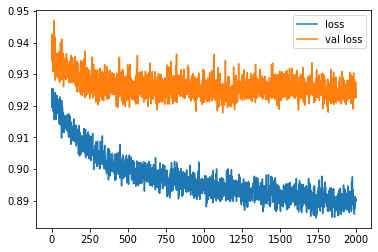

In [11]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
# smooth_loss = savgol_filter(losses, 51, 3)

plt.plot(losses, label='loss')
plt.plot(val_losses, label='val loss')
# plt.plot(smooth_loss, label='smooth loss')
plt.legend()
plt.show();

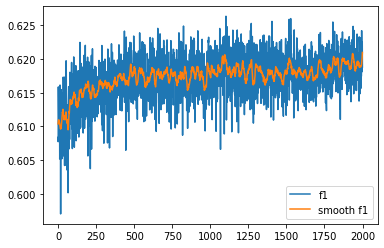

In [12]:
plt.plot(f1_scores, label='f1')
smooth_f1 = savgol_filter(f1_scores, 31, 3)
plt.plot(smooth_f1, label='smooth f1')
plt.legend()
plt.show();

In [13]:
[pred, embedding] = [x.detach().cpu().numpy() for x in net(torch.tensor(X_test).cuda())]
accuracy = (np.argmax(pred, axis=1)==y_test).mean()
f'accuracy: {accuracy*100:.2f}%'

'accuracy: 65.45%'

In [14]:
net.train(False)
embeddings = []
all_labels = []
for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs = inputs.cuda()
    embeddings.append(net(inputs)[1].detach().cpu().numpy())
    all_labels.append(labels.numpy())

embeddings=np.concatenate(embeddings)
labels=np.concatenate(all_labels)

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE()
points = tsne.fit_transform(embedding)

In [16]:
with open('dataset.pickle', 'rb') as f:
    mapping = pickle.loads(f.read())['mapping']

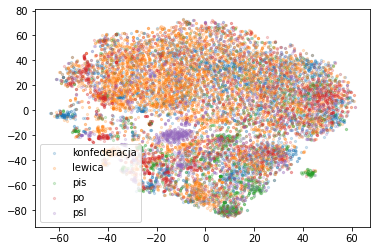

In [17]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.scatter(points[y_test==i][:,0], points[y_test==i][:,1], label=mapping[i], alpha=0.2, s=5)

plt.legend()
plt.show();